# Projet CryptoBot avec Binance

# Import des librairies

**SPRINT 3**

---

**Equipe:**

*   Sadia ABCHICHE
*   Mohamed Mehdi YOUSSEF
*   Walid SABER-CHERIF
*   Alain VONGVILAY

Consommation de la donnée

Pour cette partie,  l'algorithme LSTM (Long Short-Term Memory) qui est un RNN particulier est utilisé ici pour prédire une série temporelle (évolution du prix de la paire BTCUSDT). La prédiction nous servira d'outil d'aide à la décision pour enclencher un achat/vente du BTC.

Les données sont récupérées à des intervalles de temps de 1 jour à compter du 17 août 2017 jusqu'au 10 mai 2023

Ce modèle est adapté aux séries temporelles avec des données présentant des relations complexes et non linéaires, sans tendance ou de saisonnalité clair entre les données.

La partie réseaux de neurones récurrents de ce modèle permet de conserver une mémoire des entrées précédentes et utiliser ces informations pour faire des prédictions sur l'avenir.

In [26]:
import numpy as np
import pandas as pd
import psycopg2 as pg
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
%matplotlib inline

In [22]:
def load_data(file_path, usecols):
    """Load the dataset from a CSV file.
    Args:
        file_path (str): The path to the CSV file containing the data.
    Returns:
        pandas.DataFrame: The loaded dataset as a pandas DataFrame.
    """
    data = pd.read_csv(file_path, usecols=usecols)
    
    return data

def plot_data():
    plt.figure(figsize = (15, 5))
    plt.plot(df['open_time'], df['close_price'])
    plt.xlabel('open_time')
    plt.ylabel('close_price')
    plt.title('Variation de close_price en fonction du temps')
    plt.show()
    
def plot_result(lookback=10):
    y = np.concatenate([y_train_rescaled, y_test_rescaled])
    y_pred = np.concatenate([y_train_pred_rescaled, y_test_pred_rescaled])
    plt.figure(figsize=(15, 6))
    # Create the x-axis values
    x = np.arange(len(y))
    plt.style.use('ggplot')
    plt.plot(x, y, label='Real', color='gray')
    plt.plot(x[:len(y_train_pred)], y_train_pred_rescaled, label='Train Predicted', color='red', linestyle='--')
    plt.plot(x[len(y_train_pred) + 2*lookback :], y_test_pred_rescaled, label='Test Predicted', color='green', linestyle='--')
    plt.xlabel('Time Steps')
    plt.ylabel('Close Price')
    plt.title('Real vs Predicted Close Prices')
    plt.legend()

    plt.show()


def load_data_from_Postgres(query, host='localhost', port=5432, dbname='postgres', user='postgres', password='postgres'):
    """Load the dataset from a PostgreSQL TimescaleDB table using a SQL query.
    
    Args:
        query (str): The SQL query to load the data.
        host (str, optional): The database server address. Defaults to 'localhost'.
        port (int, optional): The database server port. Defaults to 5432.
        dbname (str, optional): The name of the database. Defaults to 'postgres'.
        user (str, optional): The username used to connect to the database. Defaults to 'postgres'.
        password (str, optional): The password used to connect to the database. Defaults to 'postgres'.
        
    Returns:
        pandas.DataFrame: The loaded dataset from Timescale DB as a pandas DataFrame.
    """
    connection_params = {
        'host': host,
        'port': port,
        'dbname': dbname,
        'user': user,
        'password': password
    }

    with pg.connect(**connection_params) as conn:
        data = pd.read_sql_query(query, conn)

    return data

def preprocess_data(data, feature_columns, target_column, test_size=0.2, batch_size=5, lookback=10, stride=1):
    """Preprocess the dataset for training and testing.
    
    Args:
        data (pandas.DataFrame): The dataset.
        feature_columns (list): The list of feature column names.
        target_column (str): The name of the target column.
        test_size (float, optional): The proportion of the dataset to include in the test split. Defaults to 0.2.
        batch_size (int, optional): The number of samples per gradient update. Defaults to 5.
        stride (int, optional): The period to apply between the timesteps in the output sequence. Defaults to 1.

        
    Returns:
        tuple: The preprocessed data as (X_train, X_test, y_train, y_test, target_scaler).
    """
    # Split the dataset into training and testing sets
    X = data[feature_columns].values.reshape(-1, 1).astype('float32')
    y = data[target_column].values.reshape(-1, 1).astype('float32')
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=False)

    # Normalize the feature columns for the training and testing sets separately
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Normalize the target data for the training and testing sets separately
    y_train = scaler.fit_transform(y_train.reshape(-1, 1)).flatten()
    y_test = scaler.transform(y_test.reshape(-1, 1)).flatten()
    
    # Create TimeseriesGenerator for the training data
    train_generator = TimeseriesGenerator(X_train, y_train, length=lookback, batch_size=batch_size, stride=stride)
    
    # Create TimeseriesGenerator for the training data
    test_generator = TimeseriesGenerator(X_test, y_test, length=lookback, batch_size=batch_size, stride=stride)
    
    print(f"Nombre d'observation dans X_train = {len(X_train)}")
    print(f"Nombre d'observation dans train_generator = {len(train_generator)}")

    return X_train, X_test, y_train, y_test, train_generator, test_generator, scaler

def create_lstm_model(lookback, num_features, units=50):
    """Create an LSTM model with the specified number of units.
    Args:
        input_shape (tuple): The shape of the input data.
        units (int, optional): The number of LSTM units. Defaults to 50.
        
    Returns:
        tf.keras.Model: The LSTM model.
    """
    model = Sequential()
    model.add(LSTM(units=units, activation='relu', return_sequences=True, input_shape=(lookback, num_features)))
    model.add(LSTM(units=units))
    model.add(Dense(1))

    model.compile(loss='mean_squared_error', optimizer='adam')
    print(model.summary())
    return model

def create_lstm_model_2(lookback, num_features, loss='mean_squared_error', optimizer='adam', units=50):
    """Create an LSTM model with the specified number of units.
    Args:
        input_shape (tuple): The shape of the input data.
        units (int, optional): The number of LSTM units. Defaults to 50.
        
    Returns:
        tf.keras.Model: The LSTM model.
    """
    # Initialize the LSTM model
    model = Sequential()

    # Add LSTM layer
    model.add(LSTM(units=units, return_sequences=True, input_shape=(lookback, num_features)))
    model.add(Dropout(0.2))

    # Add another LSTM layer
    model.add(LSTM(units=units, return_sequences=False))
    model.add(Dropout(0.2))

    # Add Dense layer
    model.add(Dense(units=25))
    model.add(Dense(units=1))

    # Compile the model
    model.compile(optimizer=optimizer, loss=loss)
    print(model.summary())
    return model

    
def train_lstm_model_generator(model, train_generator, test_generator, epochs=10):
    """Train the given LSTM model with the training data.
    
    Args:
        model (tensorflow.keras.models.Sequential): The LSTM model to be trained.
        X_train (numpy.ndarray): The training features.
        y_train (numpy.ndarray): The training target values.
        lookback (int, optional): The number of time steps to look back for generating the input sequences. Defaults to 10.
        epochs (int, optional): The number of epochs to train the model. Defaults to 50.
        batch_size (int, optional): The number of samples per gradient update. Defaults to 64.
        
    Returns:
        tensorflow.keras.models.Sequential: The trained LSTM model.
    """
    # Train the model
    # early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    model.fit_generator(generator=train_generator, epochs=epochs, validation_data=test_generator) #callbacks=[early_stopping])
    
    return model

def train_lstm_model(model, train_generator, epochs=10):
    """Train the given LSTM model with the training data.
    
    Args:
        model (tensorflow.keras.models.Sequential): The LSTM model to be trained.
        X_train (numpy.ndarray): The training features.
        y_train (numpy.ndarray): The training target values.
        lookback (int, optional): The number of time steps to look back for generating the input sequences. Defaults to 10.
        epochs (int, optional): The number of epochs to train the model. Defaults to 10.

        stride (int, optional): The period to apply between the timesteps in the output sequence. Defaults to 1.
        
    Returns:
        tensorflow.keras.models.Sequential: The trained LSTM model.
    """
    # Train the model
    early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
    model.fit(train_generator, epochs=epochs, callbacks=[early_stopping])
    
    return model

           
def evaluate_model(y_test, y_test_pred, lookback=10):
    """Evaluate the LSTM model on the test set.
    Args:
        model (tf.keras.Model): The LSTM model.
        X_test (numpy.ndarray): The test features.
        y_test (numpy.ndarray): The test target.
        sequence_length (int, optional): The length of the input sequences. Defaults to 60.
    Returns:
        float: The Root Mean Squared Error of the model on the test set.
    """
    return np.sqrt(mean_squared_error(y_test[: - lookback], y_test_pred))

def main():
    # load the data
    df = load_data("candles.csv", ["open_time", "close_price"])
    plot_data()
    
    # Preprocess the data
    X_train, X_test, y_train, y_test, train_generator, test_generator, scaler = preprocess_data(df, 'close_price', 'close_price')

    # Create LSTM model
    lstm_model = create_lstm_model(10, 1)
    
    # Train LSTM model
    trained_lstm_model = train_lstm_model(lstm_model, train_generator, epochs=10)

    # Get the model predictions for train and test sets
    y_train_pred = trained_lstm_model.predict(train_generator)
    y_test_pred = trained_lstm_model.predict(test_generator)

    # Scale the test/train data
    y_train_pred_rescaled = scaler.inverse_transform(y_train_pred)
    y_test_pred_rescaled  = scaler.inverse_transform(y_test_pred)
    y_train_rescaled      = scaler.inverse_transform(y_train.reshape(-1, 1))
    y_test_rescaled       = scaler.inverse_transform(y_test.reshape(-1, 1))
    
    rmse = evaluate_model(y_test_rescaled, y_test_pred_rescaled, lookback=10)
    print(f'Score RMSE sur échantillon test: {rmse :.2f}')
    
    plot_result(lookback=10)

In [ ]:
sql_query = """
    SELECT time_bucket('1 day', opentime) AS open_time,
           last(closeprice, closetime) AS close_price
    FROM candlestickhistorical
    GROUP BY open_time
    ORDER BY open_time;
"""

df = load_data(sql_query)

In [ ]:
main()

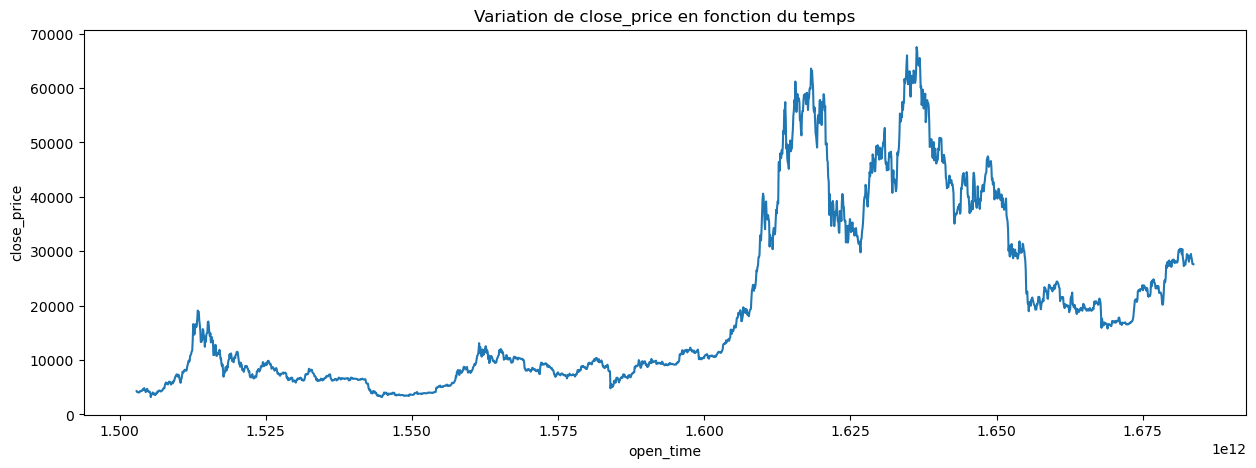

Nombre d'observation dans X_train = 1674
Nombre d'observation dans train_generator = 333
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 10, 50)            10400     
                                                                 
 lstm_9 (LSTM)               (None, 50)                20200     
                                                                 
 dense_4 (Dense)             (None, 1)                 51        
                                                                 
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5
333/333 [==============================] - 45s 132ms/step - loss: 0.0066
Epoch 2/5
333/333 [==============================] - 45s 134ms/step - loss: 0.0017
Epoch 3/5
333/333 [==============================] - 4

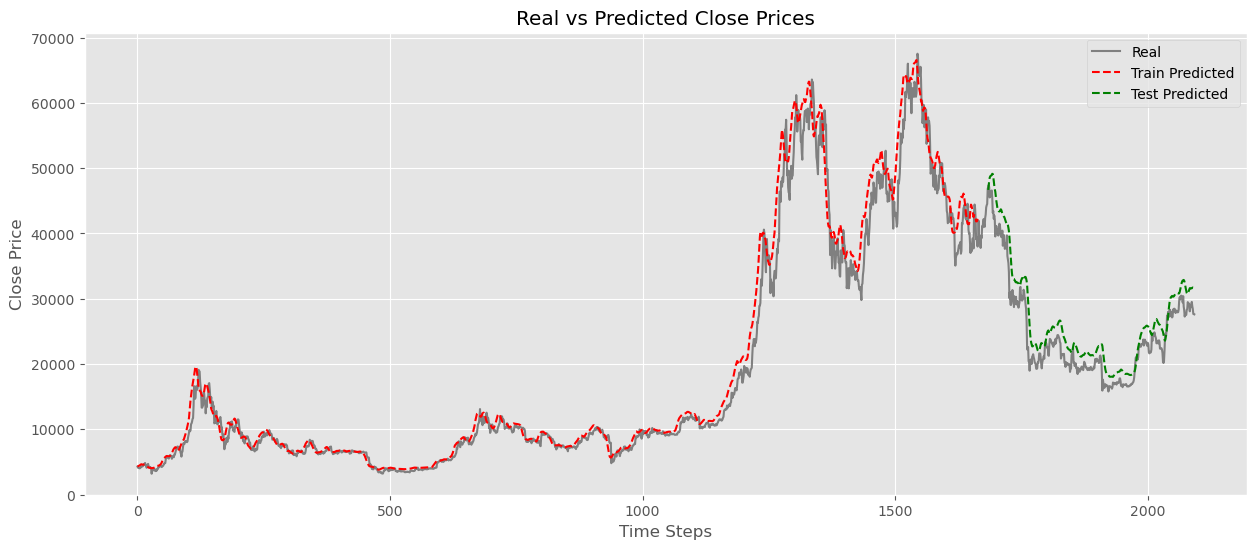

In [23]:
# load the data
df = load_data("candles.csv", ["open_time", "close_price"])
plot_data()

# Preprocess the data
X_train, X_test, y_train, y_test, train_generator, test_generator, scaler = preprocess_data(df, 'close_price', 'close_price')

# Create LSTM model
lstm_model = create_lstm_model(10, 1)

# Train LSTM model
trained_lstm_model = train_lstm_model(lstm_model, train_generator, epochs=5)

# Get the model predictions for train and test sets
y_train_pred = trained_lstm_model.predict(train_generator)
y_test_pred = trained_lstm_model.predict(test_generator)

# Scale the test/train data
y_train_pred_rescaled = scaler.inverse_transform(y_train_pred)
y_test_pred_rescaled  = scaler.inverse_transform(y_test_pred)
y_train_rescaled      = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_rescaled       = scaler.inverse_transform(y_test.reshape(-1, 1))

rmse = evaluate_model(y_test_rescaled, y_test_pred_rescaled, lookback=10)
print(f'Score RMSE sur échantillon test: {rmse :.2f}')

plot_result(lookback=10)

In [28]:
# avec plus de couches

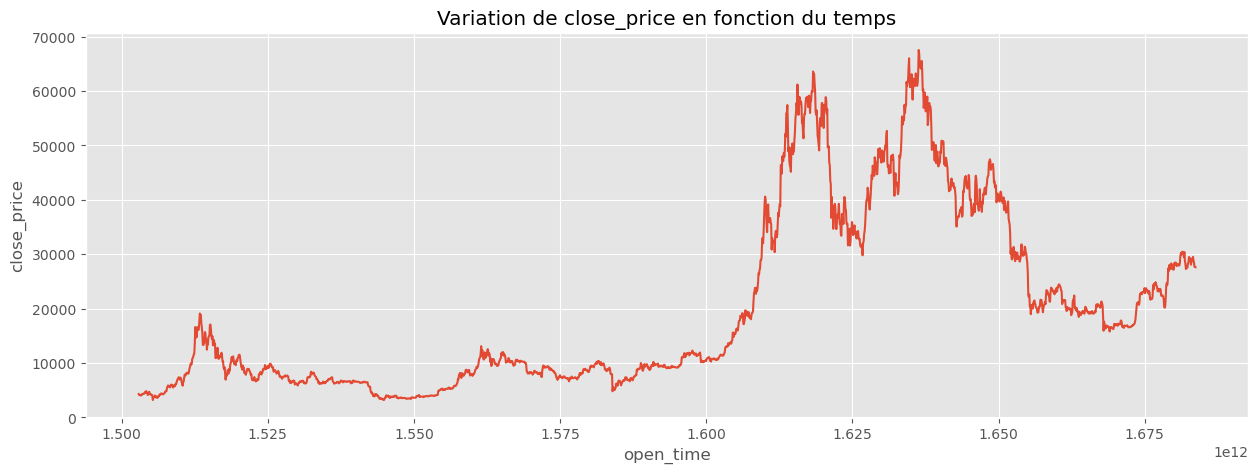

Nombre d'observation dans X_train = 1674
Nombre d'observation dans train_generator = 333
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_11 (LSTM)              (None, 10, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 10, 50)            0         
                                                                 
 lstm_12 (LSTM)              (None, 50)                20200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense_5 (Dense)             (None, 25)                1275      
                                                                 
 dense_6 (Dense)             (None, 1)                 26        
                               

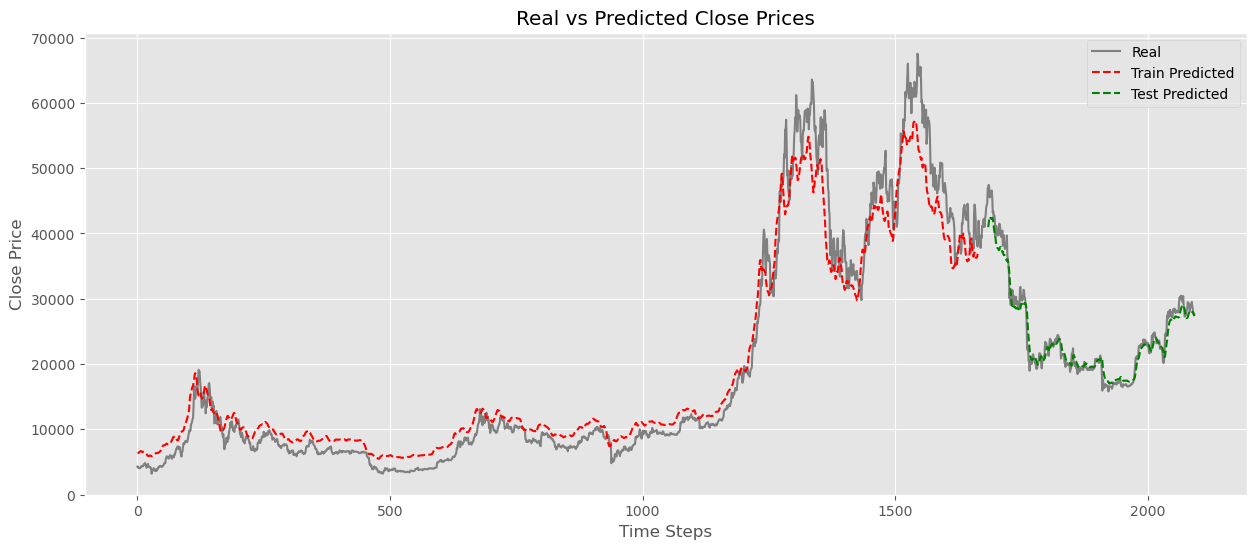

In [27]:
# load the data
df = load_data("candles.csv", ["open_time", "close_price"])
plot_data()

# Preprocess the data
X_train, X_test, y_train, y_test, train_generator, test_generator, scaler = preprocess_data(df, 'close_price', 'close_price')

# Create LSTM model
lstm_model = create_lstm_model_2(10, 1)

# Train LSTM model
trained_lstm_model = train_lstm_model(lstm_model, train_generator, epochs=10)

# Get the model predictions for train and test sets
y_train_pred = trained_lstm_model.predict(train_generator)
y_test_pred = trained_lstm_model.predict(test_generator)

# Scale the test/train data
y_train_pred_rescaled = scaler.inverse_transform(y_train_pred)
y_test_pred_rescaled  = scaler.inverse_transform(y_test_pred)
y_train_rescaled      = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_rescaled       = scaler.inverse_transform(y_test.reshape(-1, 1))

rmse = evaluate_model(y_test_rescaled, y_test_pred_rescaled, lookback=10)
print(f'Score RMSE sur échantillon test: {rmse :.2f}')

plot_result(lookback=10)

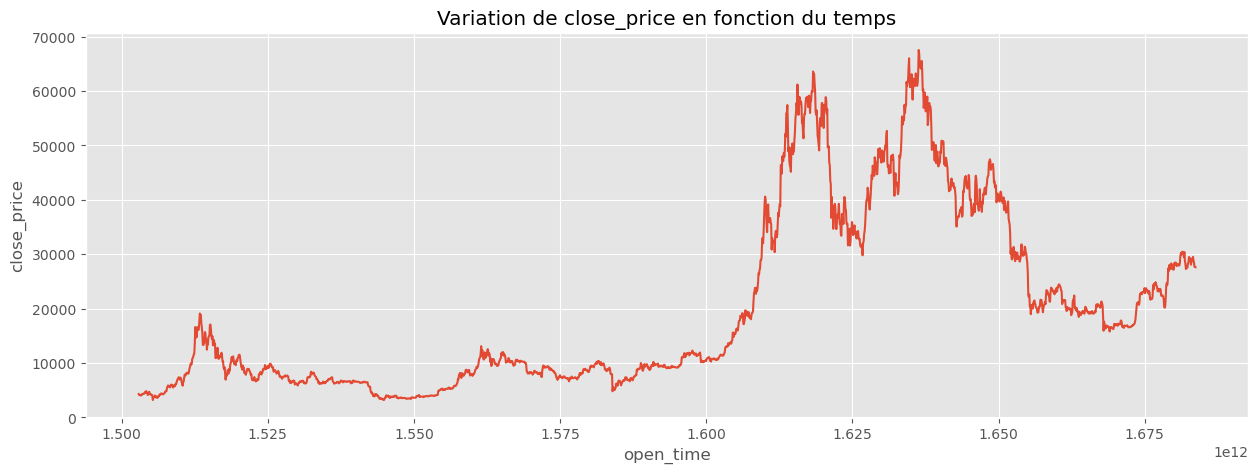

Nombre d'observation dans X_train = 1674
Nombre d'observation dans train_generator = 1664
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_13 (LSTM)              (None, 10, 50)            10400     
                                                                 
 lstm_14 (LSTM)              (None, 50)                20200     
                                                                 
 dense_7 (Dense)             (None, 1)                 51        
                                                                 
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
1664/1664 [==============================] - 226s 134ms/step - loss: 0.0028
Epoch 2/10
1664/1664 [==============================] - 228s 137ms/step - loss: 0.0012
Epoch 3/10
1664/1664 [=======================

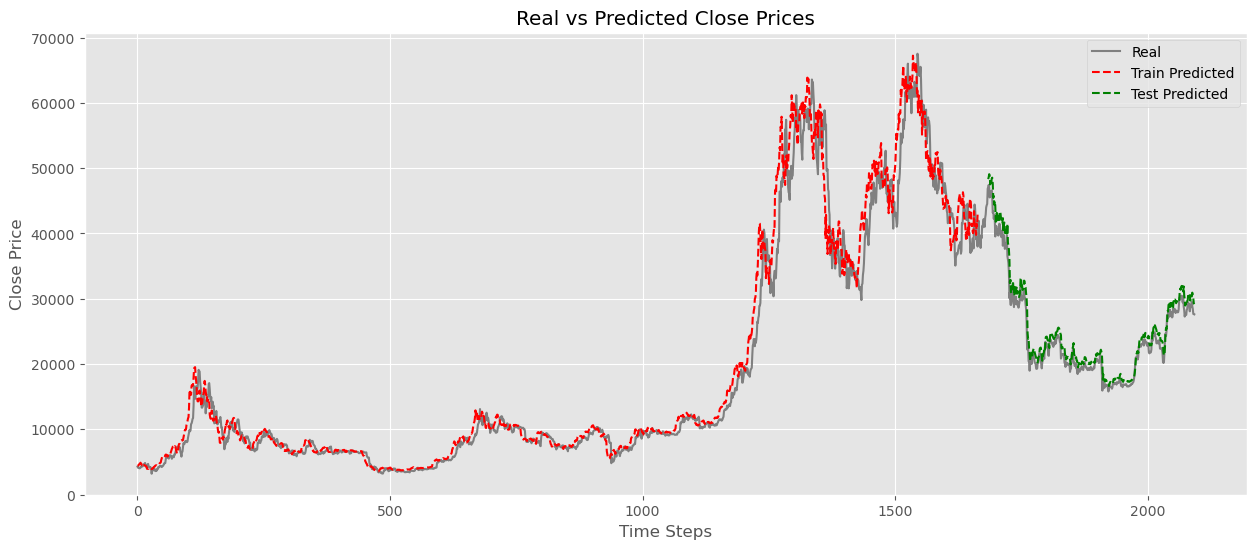

In [29]:
# load the data
df = load_data("candles.csv", ["open_time", "close_price"])
plot_data()

# Preprocess the data
X_train, X_test, y_train, y_test, train_generator, test_generator, scaler = preprocess_data(df, 'close_price', 'close_price', batch_size=1)

# Create LSTM model
lstm_model = create_lstm_model(10, 1)

# Train LSTM model
trained_lstm_model = train_lstm_model(lstm_model, train_generator, epochs=10)

# Get the model predictions for train and test sets
y_train_pred = trained_lstm_model.predict(train_generator)
y_test_pred = trained_lstm_model.predict(test_generator)

# Scale the test/train data
y_train_pred_rescaled = scaler.inverse_transform(y_train_pred)
y_test_pred_rescaled  = scaler.inverse_transform(y_test_pred)
y_train_rescaled      = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_rescaled       = scaler.inverse_transform(y_test.reshape(-1, 1))

rmse = evaluate_model(y_test_rescaled, y_test_pred_rescaled, lookback=10)
print(f'Score RMSE sur échantillon test: {rmse :.2f}')

plot_result(lookback=10)

Nombre d'observation dans X_train = 1674
Nombre d'observation dans train_generator = 557
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_15 (LSTM)              (None, 10, 50)            10400     
                                                                 
 lstm_16 (LSTM)              (None, 50)                20200     
                                                                 
 dense_8 (Dense)             (None, 1)                 51        
                                                                 
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
557/557 [==============================] - 19s 30ms/step - loss: 0.0079
Epoch 2/10
557/557 [==============================] - 17s 30ms/step - loss: 8.6782e-04
Epoch 3/10
557/557 [==============================

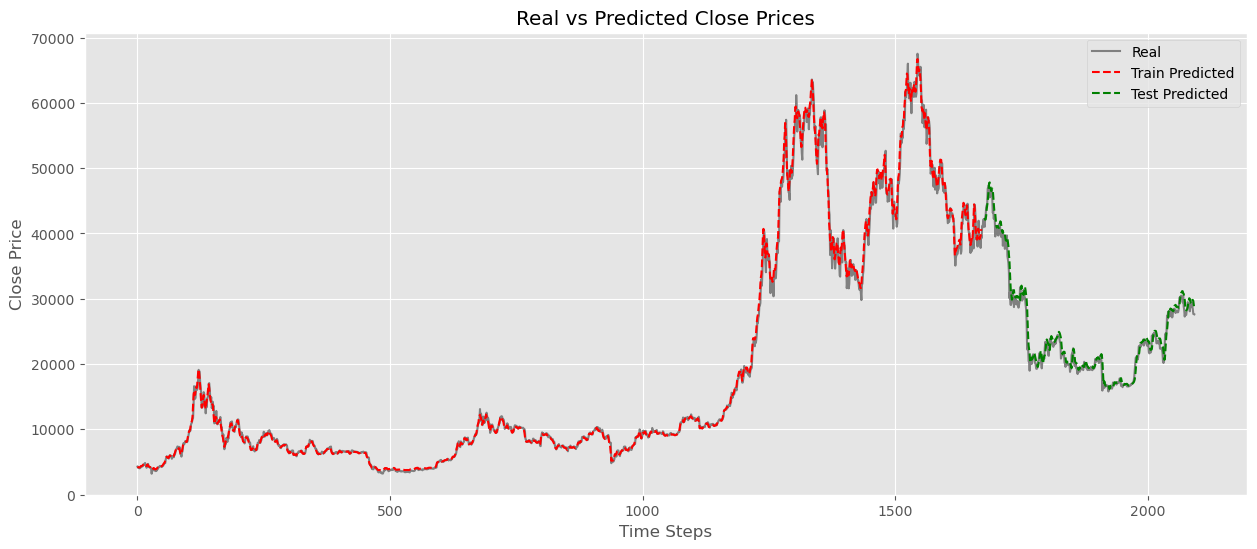

Nombre d'observation dans X_train = 1674
Nombre d'observation dans train_generator = 556
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_17 (LSTM)              (None, 10, 50)            10400     
                                                                 
 lstm_18 (LSTM)              (None, 50)                20200     
                                                                 
 dense_9 (Dense)             (None, 1)                 51        
                                                                 
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
556/556 [==============================] - 45s 80ms/step - loss: 0.0061
Epoch 2/10
556/556 [==============================] - 44s 80ms/step - loss: 0.0015
Epoch 3/10
556/556 [==============================] - 

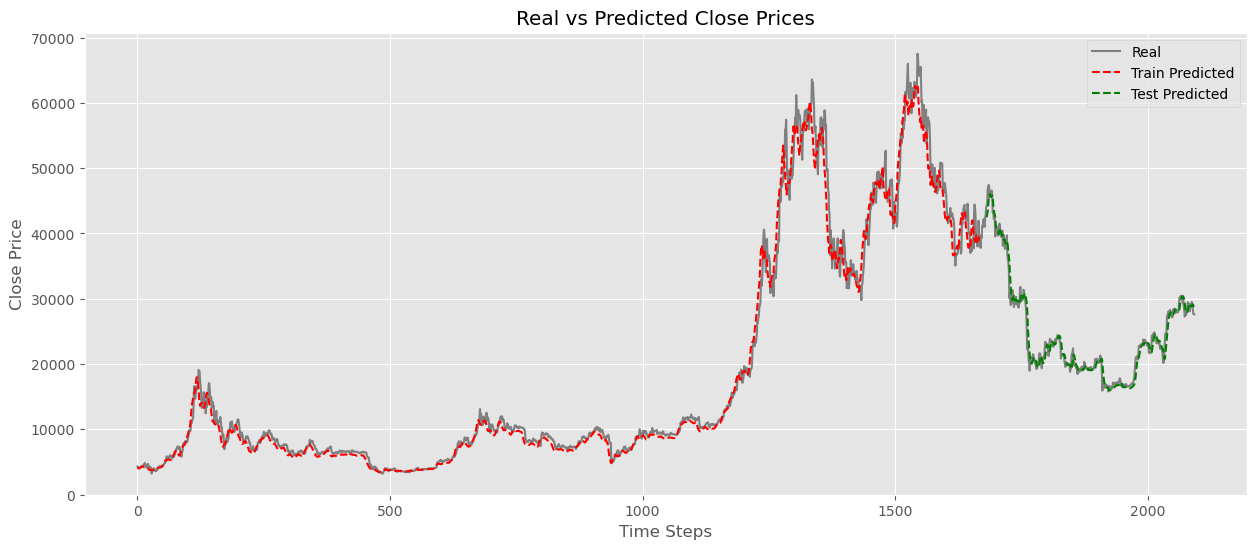

Nombre d'observation dans X_train = 1674
Nombre d'observation dans train_generator = 555
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_19 (LSTM)              (None, 10, 50)            10400     
                                                                 
 lstm_20 (LSTM)              (None, 50)                20200     
                                                                 
 dense_10 (Dense)            (None, 1)                 51        
                                                                 
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
555/555 [==============================] - 75s 133ms/step - loss: 0.0059
Epoch 2/10
555/555 [==============================] - 74s 134ms/step - loss: 0.0018
Epoch 3/10
555/555 [==============================]

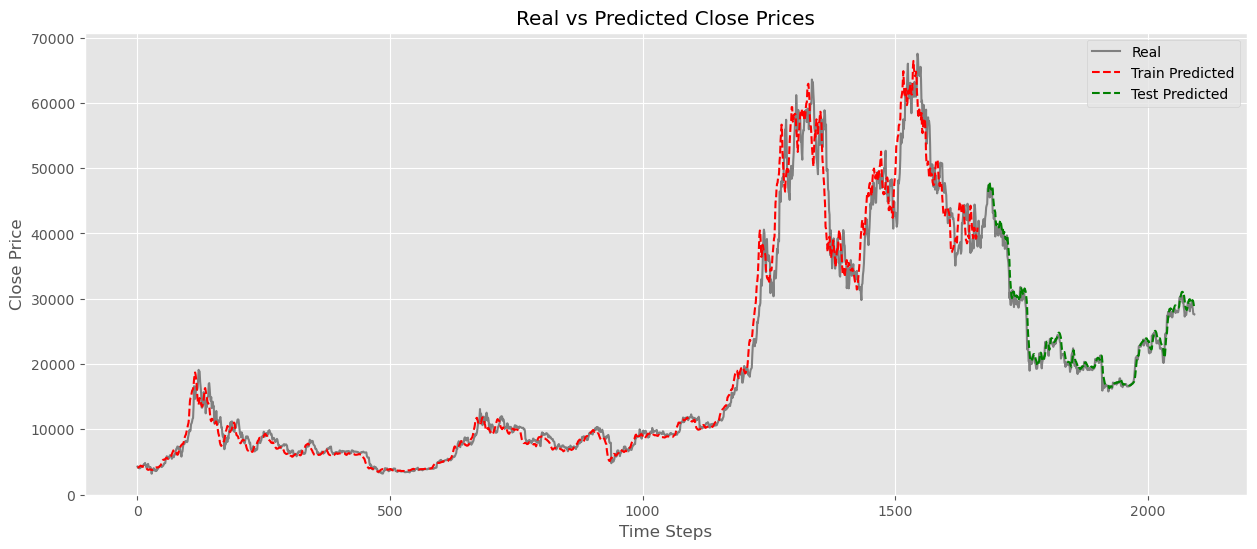

Nombre d'observation dans X_train = 1674
Nombre d'observation dans train_generator = 554
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_21 (LSTM)              (None, 10, 50)            10400     
                                                                 
 lstm_22 (LSTM)              (None, 50)                20200     
                                                                 
 dense_11 (Dense)            (None, 1)                 51        
                                                                 
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
554/554 [==============================] - 434s 781ms/step - loss: 0.0060
Epoch 2/10
554/554 [==============================] - 726s 1s/step - loss: 0.0020
Epoch 3/10
554/554 [==============================] 

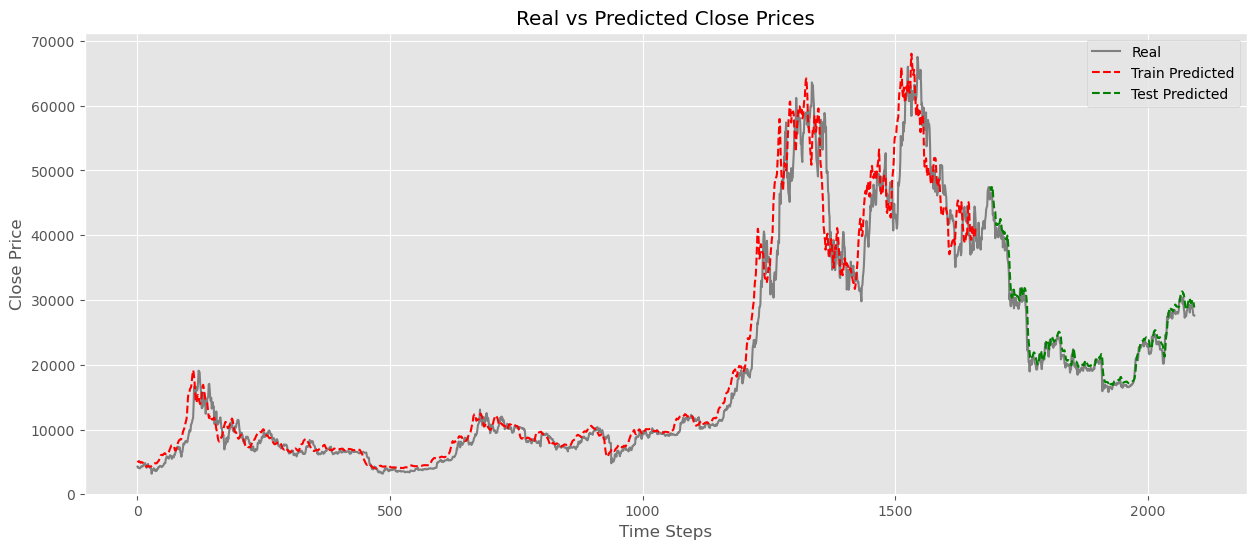

Nombre d'observation dans X_train = 1674
Nombre d'observation dans train_generator = 548
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_23 (LSTM)              (None, 10, 50)            10400     
                                                                 
 lstm_24 (LSTM)              (None, 50)                20200     
                                                                 
 dense_12 (Dense)            (None, 1)                 51        
                                                                 
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
548/548 [==============================] - 1709s 3s/step - loss: 0.0046
Epoch 2/10
548/548 [==============================] - 1706s 3s/step - loss: 0.0017
Epoch 3/10
548/548 [==============================] -

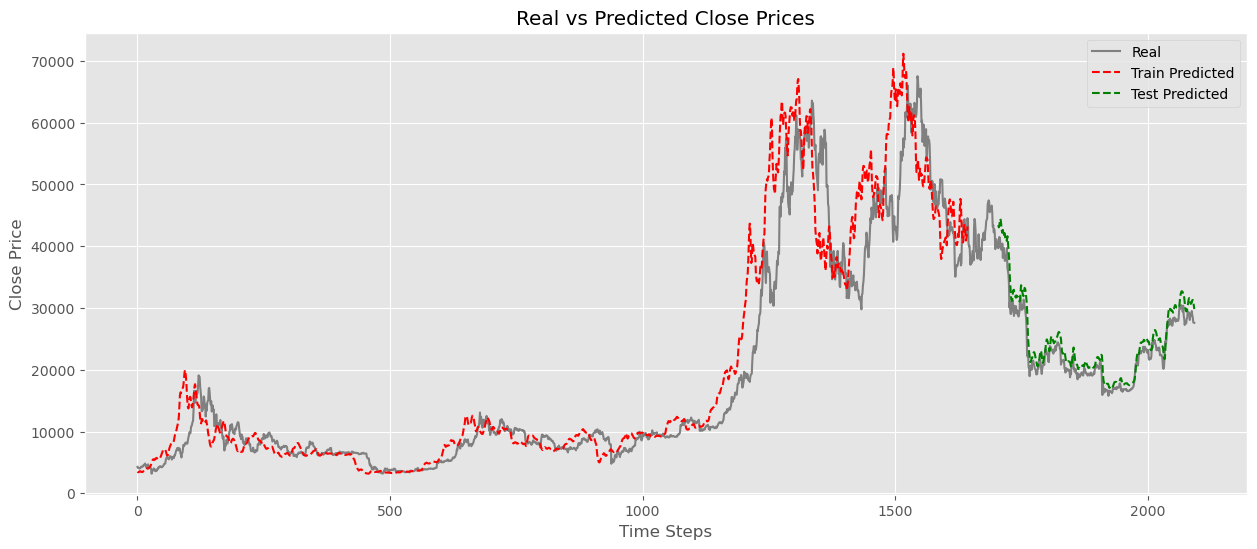

In [30]:
# load the data
# plot_data()
train_scores, test_scores = list(), list()
for day in [3, 7, 10, 14, 30]: 
    # Preprocess the data
    X_train, X_test, y_train, y_test, train_generator, test_generator, scaler = preprocess_data(df, 'close_price', 'close_price', lookback=day, batch_size=3)

    # Create LSTM model
    lstm_model = create_lstm_model(10, 1)

    # Train LSTM model
    trained_lstm_model = train_lstm_model(lstm_model, train_generator, epochs=10)

    # Get the model predictions for train and test sets
    y_train_pred = trained_lstm_model.predict(train_generator)
    y_test_pred = trained_lstm_model.predict(test_generator)

    # Scale the test/train data
    y_train_pred_rescaled = scaler.inverse_transform(y_train_pred)
    y_test_pred_rescaled  = scaler.inverse_transform(y_test_pred)
    y_train_rescaled      = scaler.inverse_transform(y_train.reshape(-1, 1))
    y_test_rescaled       = scaler.inverse_transform(y_test.reshape(-1, 1))
    
    
    rmse_train = evaluate_model(y_train_rescaled, y_train_pred_rescaled, lookback=day)
    train_scores.append(rmse_train)
    
    rmse = evaluate_model(y_test_rescaled, y_test_pred_rescaled, lookback=day)
    test_scores.append(rmse)
    print(f'Score RMSE sur échantillon test: {rmse :.2f}')

    plot_result(lookback=day)

# Modèle Retenu

Nombre d'observation dans X_train = 1674
Nombre d'observation dans train_generator = 1671
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_25 (LSTM)              (None, 3, 50)             10400     
                                                                 
 lstm_26 (LSTM)              (None, 50)                20200     
                                                                 
 dense_13 (Dense)            (None, 1)                 51        
                                                                 
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
1671/1671 [==============================] - 58s 33ms/step - loss: 0.0034
Epoch 2/10
1671/1671 [==============================] - 56s 34ms/step - loss: 7.9967e-04
Epoch 3/10
1671/1671 [======================

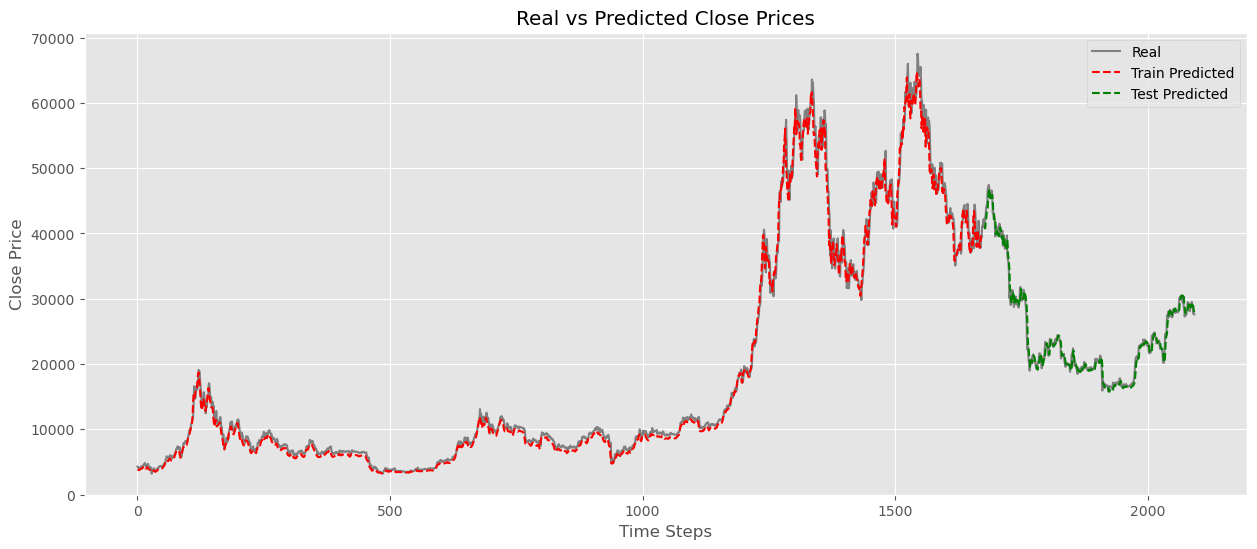

In [107]:
day = 3
X_train, X_test, y_train, y_test, train_generator, test_generator, scaler = preprocess_data(df, 'close_price', 'close_price', lookback=day, batch_size=1)

# Create LSTM model
lstm_model = create_lstm_model(day, 1)

# Train LSTM model
trained_lstm_model = train_lstm_model(lstm_model, train_generator, epochs=10)

# Get the model predictions for train and test sets
y_train_pred = trained_lstm_model.predict(train_generator)
y_test_pred = trained_lstm_model.predict(test_generator)

# Scale the test/train data
y_train_pred_rescaled = scaler.inverse_transform(y_train_pred)
y_test_pred_rescaled  = scaler.inverse_transform(y_test_pred)
y_train_rescaled      = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_rescaled       = scaler.inverse_transform(y_test.reshape(-1, 1))


rmse_train = evaluate_model(y_train_rescaled, y_train_pred_rescaled, lookback=day)
#train_scores.append(rmse_train)
print(f'Score RMSE sur échantillon test: {rmse_train :.2f}')
rmse = evaluate_model(y_test_rescaled, y_test_pred_rescaled, lookback=day)
#test_scores.append(rmse)
print(f'Score RMSE sur échantillon test: {rmse :.2f}')

plot_result(lookback=day)

In [119]:
import joblib
scaler_filename = "scaler.job"
joblib.dump(scaler, scaler_filename) 

['scaler.job']

In [112]:
trained_lstm_model.save('lstm.h5')

In [116]:
from tensorflow.keras.models import load_model
model_ = load_model('lstm.h5')

# Conclusion
Dans cette partie nous avons évaluer la performance de LSTM sur notre série temporelle. Le modèle le plus ayant obtenu le meilleur score avec la métrique RMSE est le modèle avec un lookback = 3 jours (fenêtre temporelle qu'on regarde en "arrière"). Un LSTM multivarié à également était évalué dans un autre notebook, mais les résultats moins satisfaisant nous ont suggéré de laisser de côté pour le momemt ce type d'approche.

La stratégie d'achat/vente sera déterminée dans la suite du projet.